<a href="https://colab.research.google.com/github/hamednasr/TensorFlow-Projects/blob/main/NLP_model_to_classify_sentences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP model to classify sentences of a paper and make it facile to read
In this project we build a deep learning NLP model that takes the abstract of a paper and gives it back in structured way. 

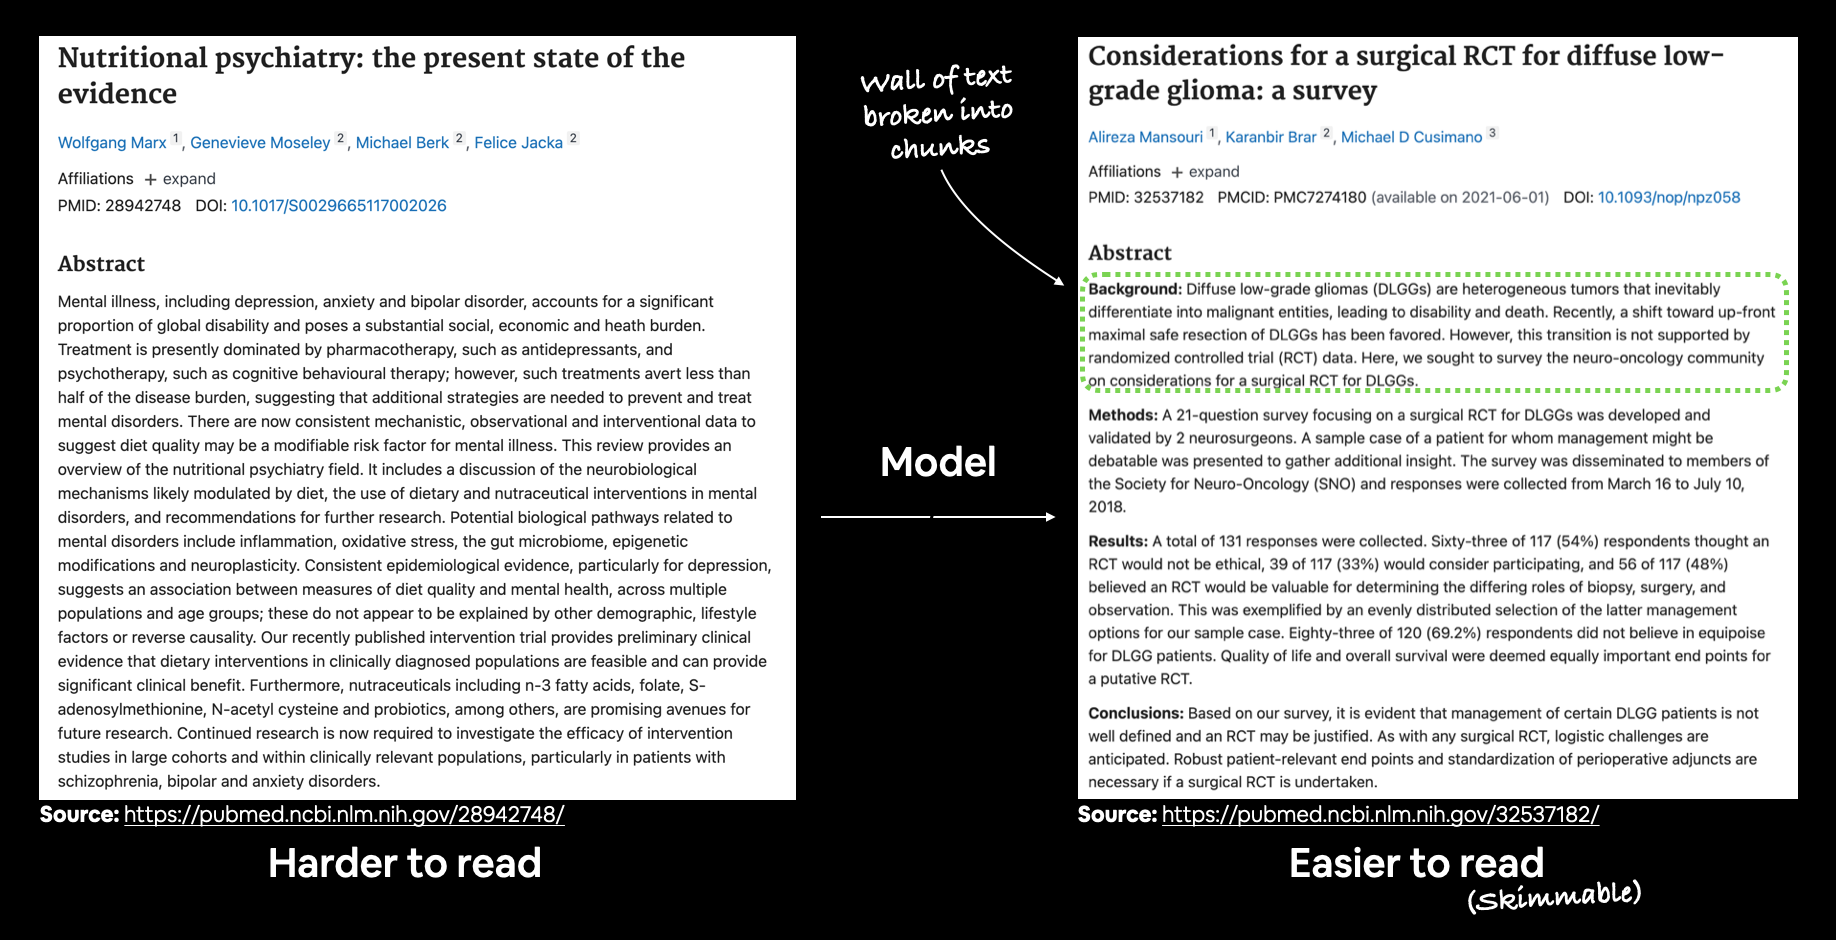

In [74]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import TextVectorization, Embedding
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from IPython import display
display.set_matplotlib_formats('svg')

In [8]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-04 09:43:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-04 09:43:04 (35.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [9]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [10]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [11]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


# Data Download and Preprocessing:
Data for this project is acquired from https://github.com/Franck-Dernoncourt/pubmed-rct 

In [12]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.


In [13]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [14]:
def read_file(filePath):

  with open(filePath, 'r') as reader:
    return reader.readlines()

In [15]:
line_list = read_file('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt')
line_list[:4]

['###24290286\n',
 'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
 'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
 'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n']

## Split text sections:
I wrote a function in order to devide the text into sentences in a dictionary

In [16]:
def split_text_sections(filePath):

  data_list=[]
  line_list = read_file(filePath)
  sentence_dict={'section':'','sentence':'','sentence_num':0,'total_sentences':0}

  for line in line_list:

    if line.startswith('###'):
      sentence_dict['total_sentences'] = 0
      sentence_dict['sentence_num'] = 0

    elif line=='\n':
      for i in range(sentence_dict['sentence_num']):   
        data_list[-1-i]['total_sentences'] = sentence_dict['sentence_num']

    else:
      sentence_dict['sentence_num'] += 1
      sentence_dict['section'] = line.split('\t')[0]
      sentence_dict['sentence'] = line.split('\t')[1].lower()
      data_list.append(sentence_dict.copy())

  return data_list


In [17]:
dev_sents = split_text_sections('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt')
print('each sentence fomrs a dictionary : \n\n')
dev_sents[:3]

each sentence fomrs a dictionary : 




[{'section': 'BACKGROUND',
  'sentence': 'ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
  'sentence_num': 1,
  'total_sentences': 10},
 {'section': 'BACKGROUND',
  'sentence': 'it is not clear whether these patients would benefit from antifungal treatment .\n',
  'sentence_num': 2,
  'total_sentences': 10},
 {'section': 'OBJECTIVE',
  'sentence': 'we sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are ige sensitized to a fumigatus .\n',
  'sentence_num': 3,
  'total_sentences': 10}]

In [18]:
train_sents = split_text_sections('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')
test_sents = split_text_sections('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt')
dev_sents = split_text_sections('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt')

In [19]:
train_df = pd.DataFrame(train_sents)
test_df = pd.DataFrame(test_sents)
dev_df = pd.DataFrame(dev_sents)

## Data exploration:

In [20]:
print('train set size:', len(list(train_df['sentence'])))
print('dev set size:', len(list(dev_df['sentence'])))
print('test set size:', len(list(test_df['sentence'])))

train set size: 180040
dev set size: 30212
test set size: 30135


In [21]:
train_df.head(15)

,section,sentence,sentence_num,total_sentences
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,1,12
1,METHODS,a total of @ patients with primary knee oa wer...,2,12
2,METHODS,outcome measures included pain reduction and i...,3,12
3,METHODS,pain was assessed using the visual analog pain...,4,12
4,METHODS,secondary outcome measures included the wester...,5,12
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",6,12
6,RESULTS,there was a clinically relevant reduction in t...,7,12
7,RESULTS,the mean difference between treatment arms ( @...,8,12
8,RESULTS,"further , there was a clinically relevant redu...",9,12
9,RESULTS,these differences remained significant at @ we...,10,12


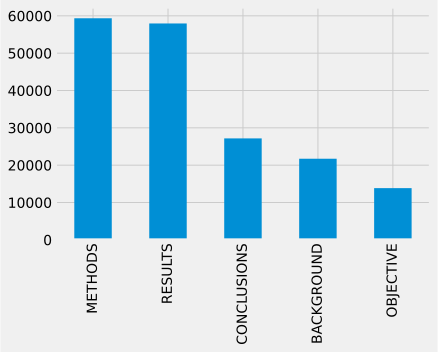

In [22]:
plt.style.use('fivethirtyeight')
train_df['section'].value_counts().plot(kind='bar')

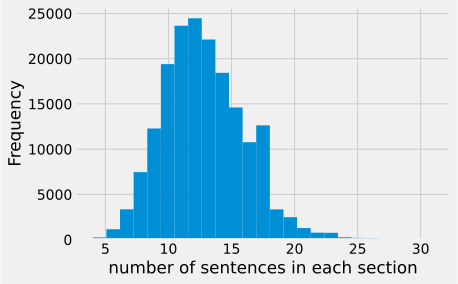

In [23]:
train_df.total_sentences.plot.hist(bins=25)
plt.xlabel('number of sentences in each section');

### Produce data sets and label-encode the section column for labels:

In [24]:
train_df['section'] = train_df['section'].\
                    map({'BACKGROUND':0 , 'OBJECTIVE':1, 'METHODS':2 , 'RESULTS':3 , 'CONCLUSIONS':4})

In [25]:
test_df['section'] = test_df['section'].\
                    map({'BACKGROUND':0 , 'OBJECTIVE':1, 'METHODS':2 , 'RESULTS':3 , 'CONCLUSIONS':4})

In [26]:
dev_df['section'] = dev_df['section'].\
                    map({'BACKGROUND':0 , 'OBJECTIVE':1, 'METHODS':2 , 'RESULTS':3 , 'CONCLUSIONS':4})

In [27]:
classes = ['BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS']

In [28]:
train_df.head()

,section,sentence,sentence_num,total_sentences
0,1,to investigate the efficacy of @ weeks of dail...,1,12
1,2,a total of @ patients with primary knee oa wer...,2,12
2,2,outcome measures included pain reduction and i...,3,12
3,2,pain was assessed using the visual analog pain...,4,12
4,2,secondary outcome measures included the wester...,5,12


In [29]:
train_df['sentence']

0         to investigate the efficacy of @ weeks of dail...
1         a total of @ patients with primary knee oa wer...
2         outcome measures included pain reduction and i...
3         pain was assessed using the visual analog pain...
4         secondary outcome measures included the wester...
                                ...                        
180035    for the absolute change in percent atheroma vo...
180036    for pav , a significantly greater percentage o...
180037    both strategies had acceptable side effect pro...
180038    compared with standard statin monotherapy , th...
180039    ( plaque regression with cholesterol absorptio...
Name: sentence, Length: 180040, dtype: object

In [30]:
train_data = train_df['sentence'].to_numpy()
train_labels = train_df['section'].to_numpy()

In [31]:
train_data ,train_labels

(array(['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .\n',
        'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
        'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
        ...,
        'both strategies had acceptable side effect profiles , with a low incidence oflaboratory abnormalities and cardiovascular events .\n',
        'compared with standard statin monotherapy , the combination of statin plus ezetimibe showed greater coronary plaque regression , which might be attributed to cholesterol absorption inhibition-induced aggressive lipid lowering .\n',
        '( plaque regression wit

In [32]:
test_data = test_df['sentence'].to_numpy()
test_labels = test_df['section'].to_numpy()

In [33]:
dev_data = dev_df['sentence'].to_numpy()
dev_labels = dev_df['section'].to_numpy()

In [34]:
len(train_data[1].split(' '))

27

In [35]:
# %pprint

In [36]:
word_nums_train = list([len(sent.split(' ')) for sent in train_data])
word_nums_train[:25]

[49,
 27,
 15,
 14,
 35,
 29,
 30,
 55,
 36,
 8,
 32,
 39,
 12,
 26,
 33,
 40,
 22,
 23,
 27,
 26,
 27,
 34,
 41,
 18,
 9]

In [37]:
print('longest sentence: ', max(word_nums_train))

longest sentence:  296


In [38]:
print('shortest sentence: ', min(word_nums_train))

shortest sentence:  1


In [39]:
print('sentence average length: ', np.mean(word_nums_train))

sentence average length:  26.338269273494777


In [40]:
print('median of sentences length: ', np.median(word_nums_train))

median of sentences length:  23.0


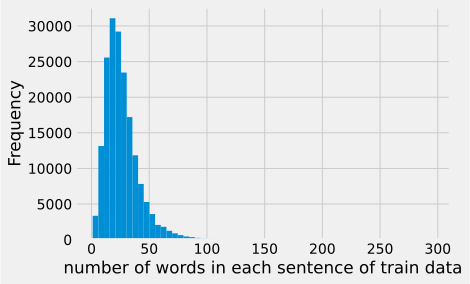

In [41]:
plt.hist(word_nums_train,bins=60);
plt.ylabel('Frequency')
plt.xlabel('number of words in each sentence of train data');

## 

## Creating TensorFlow Datasets:

In [42]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data ,train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data ,test_labels))
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_data ,dev_labels))

In [43]:
train_dataset = train_dataset.batch(32).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(buffer_size = tf.data.AUTOTUNE)
dev_dataset = dev_dataset.batch(32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [44]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Text Vectorizer and Embedding:

In [85]:
text_vectorizer = TextVectorization(max_tokens=60000,
                                    standardize='lower_and_strip_punctuation',
                                    split='whitespace',
                                    ngrams=None,
                                    output_mode='int',
                                    output_sequence_length=50,
                                    name='vectorizer_word')

In [46]:
text_vectorizer.adapt(train_data)

In [47]:
text_vectorizer(train_data[2])

<tf.Tensor: shape=(50,), dtype=int64, numpy=
array([ 86, 213, 121,  65, 169,   3, 194,   5, 149, 119,   3, 670, 636,
       747,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])>

In [48]:
vocabs = text_vectorizer.get_vocabulary()
vocabs[:10]

['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']

In [49]:
len(vocabs)

60000

In [81]:
embed = Embedding(input_dim = 60000,
                  output_dim = 128,
                  input_length=50,
                  mask_zero = False,
                  name = 'embed_word')

In [51]:
embed(text_vectorizer(train_data[12])).shape

TensorShape([50, 128])

# Experiment with different models:

# Model 0: Baseline model with Naive Bayes and TF-IDF:

In [ ]:
model_0 = Pipeline([ ('tfvect', TfidfVectorizer()),
                  ('MNB', MultinomialNB())
                ])

model_0.fit(train_data, train_labels)

Pipeline(steps=[('tfvect', TfidfVectorizer()), ('MNB', MultinomialNB())])

In [ ]:
model_0.score(test_data , test_labels)

0.716674962667994

In [ ]:
pred_labels = model_0.predict(test_data)
pred_labels

array([2, 2, 2, ..., 3, 3, 3])

In [ ]:
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.65      0.47      0.54      3621
           1       0.74      0.13      0.22      2333
           2       0.72      0.88      0.79      9897
           3       0.76      0.85      0.80      9713
           4       0.63      0.58      0.60      4571

    accuracy                           0.72     30135
   macro avg       0.70      0.58      0.59     30135
weighted avg       0.71      0.72      0.69     30135



# Model 1: Conv1D with token embedding:

## Model Creation:

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='inputs')

x = text_vectorizer(inputs)

x = embed(x)

x = tf.keras.layers.Conv1D(256, 3, activation='relu')(x)

x = tf.keras.layers.GlobalAvgPool1D()(x)

# x = tf.keras.layers.Dense(32, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_1 = tf.keras.Model(inputs, outputs, name ='Conv1D')

In [ ]:
model_1.summary()

Model: "Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 50)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 50, 128)           7680000   
                                                                 
 conv1d_3 (Conv1D)           (None, 48, 256)           98560     
                                                                 
 global_average_pooling1d_5   (None, 256)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_13 (Dense)            (None, 5)                 1285 

In [ ]:
model_1.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
history_1 = model_1.fit(train_dataset,
                        epochs = 5, 
                        validation_data=dev_dataset)

Epoch 1/5
5627/5627 [==============================] - 53s 9ms/step - loss: 0.6145 - accuracy: 0.7752 - val_loss: 0.5426 - val_accuracy: 0.8055
Epoch 2/5
5627/5627 [==============================] - 52s 9ms/step - loss: 0.4503 - accuracy: 0.8426 - val_loss: 0.5423 - val_accuracy: 0.8090
Epoch 3/5
5627/5627 [==============================] - 52s 9ms/step - loss: 0.3606 - accuracy: 0.8766 - val_loss: 0.5894 - val_accuracy: 0.8020
Epoch 4/5
5627/5627 [==============================] - 52s 9ms/step - loss: 0.2852 - accuracy: 0.9058 - val_loss: 0.6676 - val_accuracy: 0.7937
Epoch 5/5
5627/5627 [==============================] - 53s 9ms/step - loss: 0.2228 - accuracy: 0.9289 - val_loss: 0.7743 - val_accuracy: 0.7829


I changed mask_zero = False, and True. not really different in result

## Evaluation:

In [ ]:
model_1.evaluate(test_dataset)

942/942 [==============================] - 3s 3ms/step - loss: 0.7887 - accuracy: 0.7770


[0.7887018918991089, 0.7770034670829773]

In [ ]:
pred_probs = model_1.predict(test_dataset)
pred_probs[0]

array([0.3472 , 0.2856 , 0.2074 , 0.1422 , 0.01753], dtype=float16)

In [ ]:
pred_labels = np.argmax(pred_probs,axis=1)
pred_labels

array([0, 3, 2, ..., 3, 3, 3])

### Classification Report:

In [ ]:
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.60      0.62      0.61      3621
           1       0.63      0.48      0.54      2333
           2       0.87      0.85      0.86      9897
           3       0.81      0.87      0.84      9713
           4       0.70      0.69      0.70      4571

    accuracy                           0.78     30135
   macro avg       0.72      0.70      0.71     30135
weighted avg       0.77      0.78      0.77     30135



### Confusion Matrix:

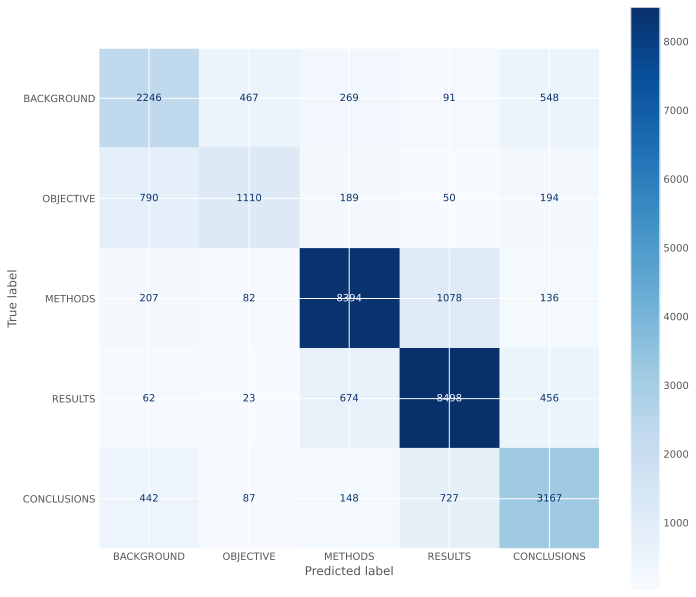

In [ ]:
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap= 'Blues');

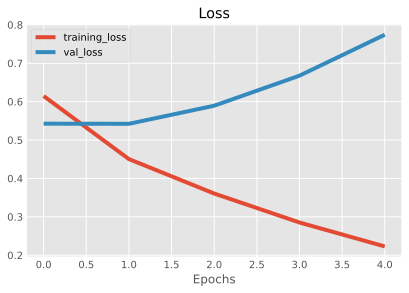

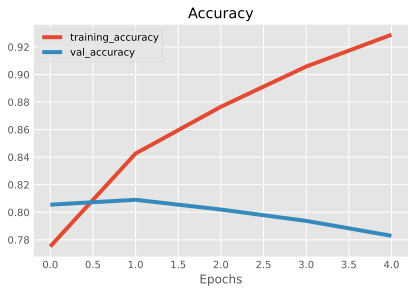

In [ ]:
plt.style.use('ggplot')
plot_loss_curves(history_1)

# Model 2: Universal Sentence Encoder Feature Extractor Pretrained Model with Token Embedding:

## Model_2 Creation:

In [ ]:
encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                        trainable = False,
                        input_shape=[],
                        dtype=tf.string,
                        name= 'USE')


inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='inputs')

x = encoder_layer(inputs)

x = tf.keras.layers.Dense(32, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_2 = tf.keras.Model(inputs, outputs, name ='USE')

In [ ]:
model_2.summary()

Model: "USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_11 (Dense)            (None, 32)                16416     
                                                                 
 dense_12 (Dense)            (None, 5)                 165       
                                                                 
Total params: 256,814,405
Trainable params: 16,581
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_2.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
history_2 = model_2.fit(train_dataset,
                        epochs = 5, 
                        validation_data=dev_dataset)

Epoch 1/5
5627/5627 [==============================] - 69s 12ms/step - loss: 0.6814 - accuracy: 0.7405 - val_loss: 0.6643 - val_accuracy: 0.7477
Epoch 2/5
5627/5627 [==============================] - 70s 13ms/step - loss: 0.6532 - accuracy: 0.7509 - val_loss: 0.6478 - val_accuracy: 0.7547
Epoch 3/5
5627/5627 [==============================] - 70s 12ms/step - loss: 0.6369 - accuracy: 0.7574 - val_loss: 0.6396 - val_accuracy: 0.7575
Epoch 4/5
5627/5627 [==============================] - 70s 12ms/step - loss: 0.6263 - accuracy: 0.7611 - val_loss: 0.6345 - val_accuracy: 0.7600
Epoch 5/5
5627/5627 [==============================] - 69s 12ms/step - loss: 0.6185 - accuracy: 0.7644 - val_loss: 0.6307 - val_accuracy: 0.7611


## Evaluation:

In [ ]:
model_2.evaluate(test_dataset)

942/942 [==============================] - 10s 10ms/step - loss: 0.6486 - accuracy: 0.7525


[0.648568868637085, 0.7525137066841125]

In [ ]:
pred_probs = model_2.predict(test_dataset)
pred_probs[0]

array([0.1327 , 0.1548 , 0.10266, 0.4265 , 0.1833 ], dtype=float16)

In [ ]:
pred_labels = np.argmax(pred_probs,axis=1)
pred_labels

array([3, 1, 2, ..., 3, 3, 4])

### Classification Report:

In [ ]:
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.59      0.60      0.59      3621
           1       0.72      0.45      0.55      2333
           2       0.81      0.86      0.83      9897
           3       0.80      0.84      0.82      9713
           4       0.66      0.62      0.64      4571

    accuracy                           0.75     30135
   macro avg       0.71      0.67      0.69     30135
weighted avg       0.75      0.75      0.75     30135



### Confusion Matrix:

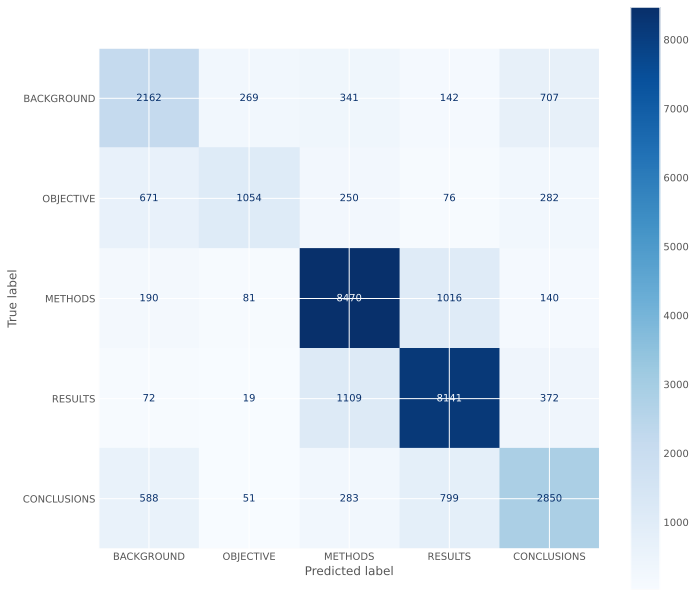

In [ ]:
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap= 'Blues');

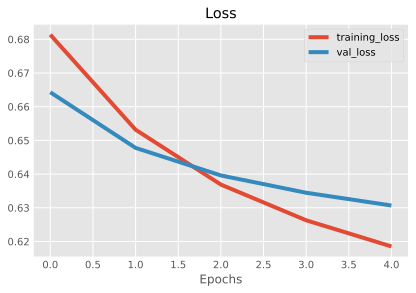

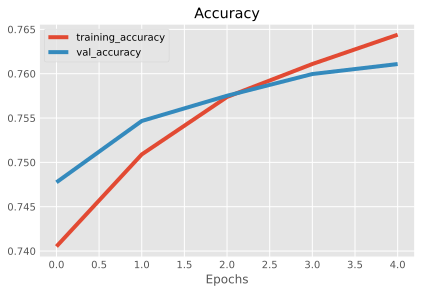

In [ ]:
plt.style.use('ggplot')
plot_loss_curves(history_2)

# Character embedding:

In [52]:
' '.join(list(train_data[1]))

'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   . \n'

In [53]:
train_data

array(['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .\n',
       'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
       'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
       ...,
       'both strategies had acceptable side effect profiles , with a low incidence oflaboratory abnormalities and cardiovascular events .\n',
       'compared with standard statin monotherapy , the combination of statin plus ezetimibe showed greater coronary plaque regression , which might be attributed to cholesterol absorption inhibition-induced aggressive lipid lowering .\n',
       '( plaque regression with chole

In [54]:
train_character = [' '.join(list(sentence)) for sentence in train_data]
train_character[:3]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   . \n',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   . \n',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e 

In [55]:
test_character = [' '.join(list(sentence)) for sentence in test_data]
dev_character = [' '.join(list(sentence)) for sentence in dev_data]

In [56]:
char_nums_train = [len(sent) for sent in train_data]
char_nums_train[:25]

[282,
 138,
 112,
 66,
 210,
 148,
 162,
 165,
 181,
 52,
 189,
 249,
 80,
 168,
 176,
 246,
 121,
 141,
 164,
 187,
 163,
 192,
 252,
 115,
 71]

In [57]:
print('longest sentence: ', max(char_nums_train))

longest sentence:  1387


In [58]:
print('shortest sentence: ', min(char_nums_train))

shortest sentence:  2


In [59]:
print('sentence average length: ', np.mean(char_nums_train))

sentence average length:  150.3662574983337


In [60]:
print('median of sentences length: ', np.median(char_nums_train))

median of sentences length:  138.0


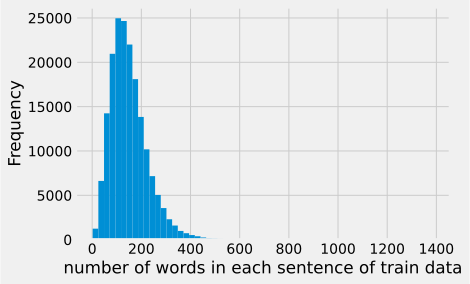

In [61]:
plt.hist(char_nums_train,bins=60);
plt.ylabel('Frequency')
plt.xlabel('number of words in each sentence of train data');

## Creating TensorFlow Character Datasets:

In [62]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_character ,train_labels))
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_character ,test_labels))
dev_char_dataset = tf.data.Dataset.from_tensor_slices((dev_character ,dev_labels))

In [63]:
train_char_dataset = train_char_dataset.batch(32).prefetch(buffer_size = tf.data.AUTOTUNE)
test_char_dataset = test_char_dataset.batch(32).prefetch(buffer_size = tf.data.AUTOTUNE)
dev_char_dataset = dev_char_dataset.batch(32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [64]:
train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Text Vectorizer and Embedding for characters:

In [86]:
text_char_vectorizer = TextVectorization(max_tokens=28,
                                    standardize='lower_and_strip_punctuation',
                                    split='whitespace',
                                    ngrams=None,
                                    output_mode='int',
                                    output_sequence_length=300,
                                    name= 'vectorizer_char')

In [66]:
text_char_vectorizer.adapt(train_character)

In [67]:
text_char_vectorizer(train_character[0])

<tf.Tensor: shape=(300,), dtype=int64, numpy=
array([ 3,  7,  4,  6, 21,  2,  9,  3,  4, 18,  5,  3,  2,  3, 13,  2,  2,
       17, 17,  4, 11,  5, 11, 19,  7, 17, 20,  2,  2, 23,  9,  7, 17, 10,
        5,  4, 12, 19, 12,  7, 20, 10,  7,  9,  2,  7,  8,  5, 12, 14,  8,
        2, 10,  6,  4,  9,  7, 12,  7,  6,  2,  4,  6,  4, 15, 14,  8,  7,
       21,  4,  6, 18, 14,  5,  4,  6, 15,  7, 22,  4, 12,  4,  3, 19,  5,
        6, 10,  9, 19,  9,  3,  2, 15,  4, 11, 12,  7, 20, 18,  8,  5, 10,
        2,  4,  6, 17, 12,  5, 15, 15,  5,  3,  4,  7,  6,  4,  6,  3, 13,
        2,  9, 13,  7,  8,  3,  3,  2,  8, 15,  5,  6, 10, 20, 13,  2,  3,
       13,  2,  8,  3, 13,  2,  2, 17, 17,  2, 11,  3, 20,  7, 16, 12, 10,
       22,  2,  9, 16,  9,  3,  5,  4,  6,  2, 10,  5,  3, 20,  2,  2, 23,
        9,  4,  6,  7, 12, 10,  2,  8,  5, 10, 16, 12,  3,  9, 20,  4,  3,
       13, 15,  7, 10,  2,  8,  5,  3,  2,  3,  7,  9,  2, 21,  2,  8,  2,
       23,  6,  2,  2,  7,  9,  3,  2,  7,  5,  8,  3,

In [68]:
chars = text_char_vectorizer.get_vocabulary()
chars[:10]

['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's']

In [69]:
len(vocabs)

60000

In [70]:
embed_char = Embedding(input_dim = 28,
                  output_dim = 128,
                  input_length=300,
                  name='ember_char')

In [71]:
embed_char(text_char_vectorizer(train_character[0])).shape

TensorShape([300, 128])

# Model 3: Conv1D with Character embedding:

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='inputs')

x = text_char_vectorizer(inputs)

x = embed_char(x)

x = tf.keras.layers.Conv1D(256, 3, activation='relu')(x)

x = tf.keras.layers.GlobalMaxPool1D()(x)

# x = tf.keras.layers.Dense(32, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_3 = tf.keras.Model(inputs, outputs, name ='Conv1D')

In [ ]:
model_3.summary()

Model: "Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1)]               0         
                                                                 
 text_vectorization_7 (TextV  (None, 300)              0         
 ectorization)                                                   
                                                                 
 ember_char (Embedding)      (None, 300, 128)          3584      
                                                                 
 conv1d_5 (Conv1D)           (None, 298, 256)          98560     
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_15 (Dense)            (None, 5)                 1285 

In [ ]:
model_3.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
history_3 = model_3.fit(train_char_dataset,
                        epochs = 5, 
                        validation_data=dev_char_dataset)

Epoch 1/5
5627/5627 [==============================] - 37s 6ms/step - loss: 0.8477 - accuracy: 0.6719 - val_loss: 0.7645 - val_accuracy: 0.7151
Epoch 2/5
5627/5627 [==============================] - 35s 6ms/step - loss: 0.7371 - accuracy: 0.7197 - val_loss: 0.7356 - val_accuracy: 0.7246
Epoch 3/5
5627/5627 [==============================] - 36s 6ms/step - loss: 0.7071 - accuracy: 0.7321 - val_loss: 0.7166 - val_accuracy: 0.7311
Epoch 4/5
5627/5627 [==============================] - 35s 6ms/step - loss: 0.6880 - accuracy: 0.7400 - val_loss: 0.7192 - val_accuracy: 0.7303
Epoch 5/5
5627/5627 [==============================] - 36s 6ms/step - loss: 0.6752 - accuracy: 0.7462 - val_loss: 0.7166 - val_accuracy: 0.7328


I changed mask_zero = False, and True. not really different in result

## Evaluation:

In [ ]:
model_3.evaluate(test_char_dataset)

942/942 [==============================] - 3s 4ms/step - loss: 0.7343 - accuracy: 0.7273


[0.7342836856842041, 0.7273270487785339]

In [ ]:
pred_probs = model_3.predict(test_char_dataset)
pred_probs[0]

array([0.1852 , 0.09796, 0.2094 , 0.1917 , 0.316  ], dtype=float16)

In [ ]:
pred_labels = np.argmax(pred_probs,axis=1)
pred_labels

array([4, 3, 2, ..., 3, 3, 4])

### Classification Report:

In [ ]:
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.54      0.62      0.58      3621
           1       0.81      0.24      0.38      2333
           2       0.81      0.83      0.82      9897
           3       0.73      0.88      0.80      9713
           4       0.68      0.50      0.58      4571

    accuracy                           0.73     30135
   macro avg       0.71      0.62      0.63     30135
weighted avg       0.73      0.73      0.71     30135



### Confusion Matrix:

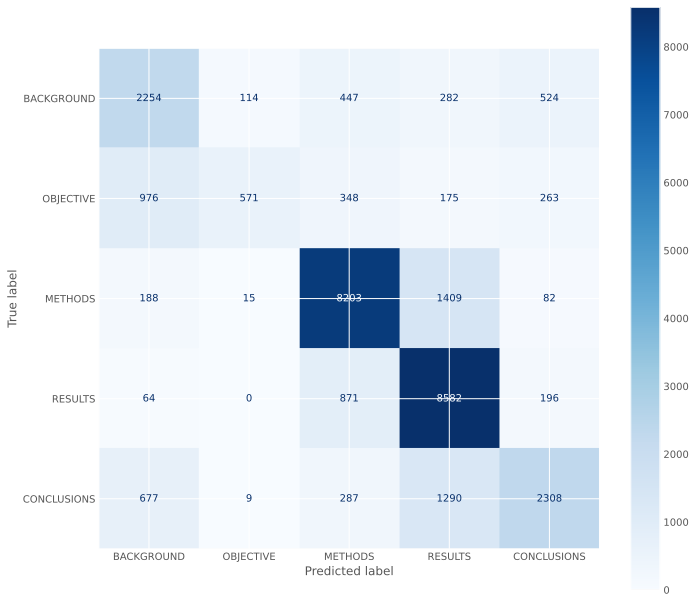

In [ ]:
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap= 'Blues');

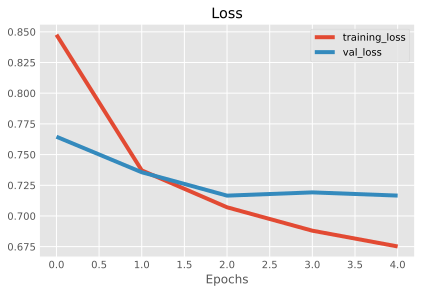

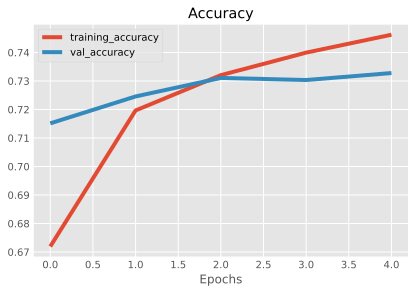

In [ ]:
plt.style.use('ggplot')
plot_loss_curves(history_3)

# Model 4: Character Embedding + Token Embedding Model:
### I created the model described in this paper with little change: Neural Networks for Joint Sentence Classification in Medical Paper Abstracts. Franck Dernoncourt, Ji Young Lee, Peter Szolovits, 2016
https://arxiv.org/abs/1612.05251

### I first create the model based on token embedding and then a model base on character embedding, then I concatenate them.

In [96]:
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='token_input')
x = embed(text_vectorizer(token_inputs))
x = tf.keras.layers.GlobalAvgPool1D()(x)
token_outputs = tf.keras.layers.Dense(32, activation='relu',name='token_output')(x)
token_model = tf.keras.Model(token_inputs, token_outputs)

char_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='char_input')
x = embed_char(text_char_vectorizer(char_inputs))
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)
char_outputs = tf.keras.layers.Dense(16, activation='relu',name='char_output')(x)
char_model = tf.keras.Model(char_inputs, char_outputs)

concat_layer = tf.keras.layers.Concatenate(name='hybrid_layer')([token_model.output, char_model.output])

x = tf.keras.layers.Dropout(0.5)(concat_layer)
# x = tf.keras.layers.Dense(16, activation='relu')(x)
outputs = tf.keras.layers.Dense(5 , activation='softmax')(x)

model_4 = tf.keras.Model(inputs= [token_inputs, char_inputs], 
                             outputs = outputs, 
                             name='final_hybrid_model')

In [97]:
 model_4.summary()

Model: "final_hybrid_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 vectorizer_word (TextVectoriza  (None, 50)          0           ['token_input[0][0]']            
 tion)                                                                                            
                                                                                                  
 vectorizer_char (TextVectoriza  (None, 300)         0           ['char_input[0][

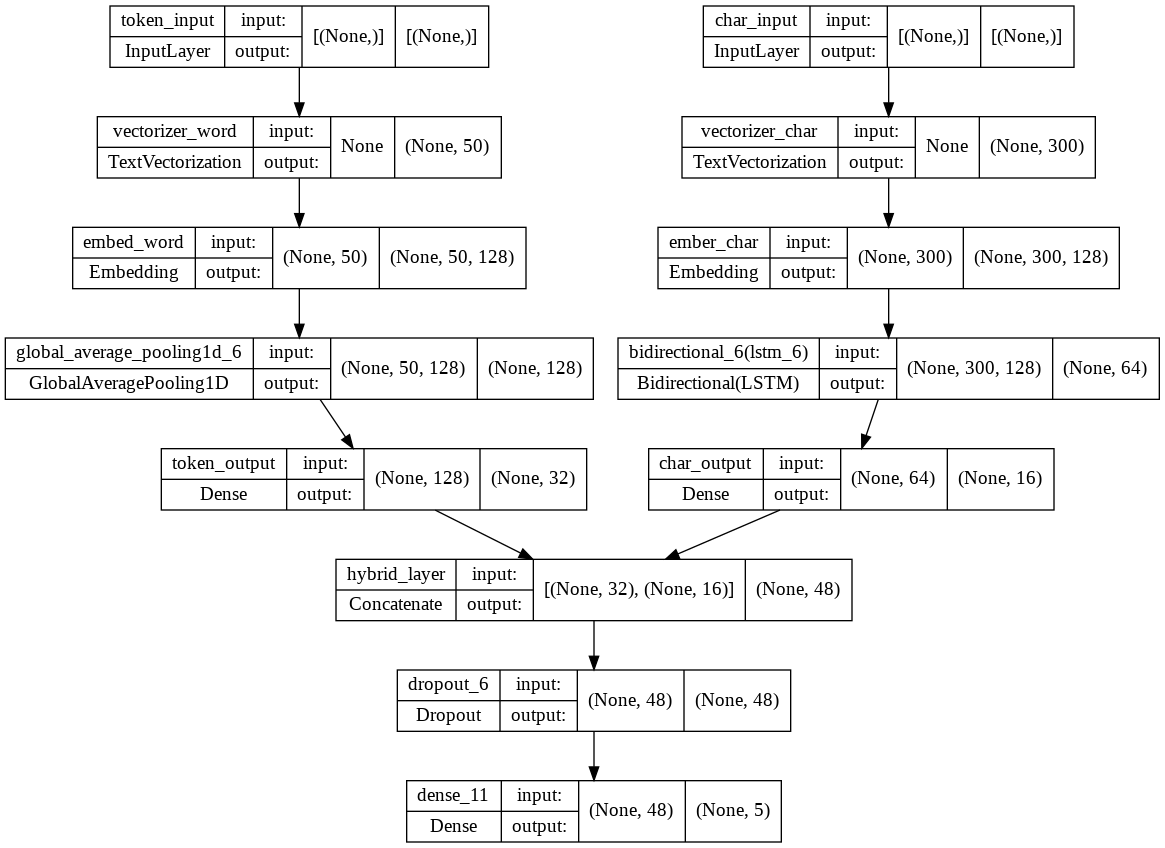

In [98]:
plot_model(model_4, show_shapes=True)

In [99]:
model_4.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                    optimizer = tf.keras.optimizers.Adam(),
                    metrics = ['accuracy'])